# Basic regression with a neural network and a samll data set

### This a set of examples to examine the very basics of regression with neural networks. The tests are based on an example in section 3.6 of Francois Chollet's book *Deep Learning with Python*

In [1]:
from keras import models, layers
from keras.datasets import boston_housing

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


For the purpose of these tests, we will be using a dataset of home information in a 1970s Boston suburb to model the values of houses. Each home has 13 attributes and its price. There are only 404 training samples to use. We will create a model that describes how these attributes relate to the homes price.

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

I have put the training data into a dataframe and displayed the first five homes' attributes below. This makes it easy to see that the values vary in their ranges when comparing features. We need to normalize our data to prevent the larger features from overpowering the smaller features.

In [3]:
training_data_dataframe = pd.DataFrame(data=train_data)
training_data_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


To normalize the data, we will subtract the means of the testing data from the respective features. This will center all of the data around zero. We will then divide the inputs by the standard deviation in their respective features. This will condense them all into a similar range. As we can see below, the values in each feature are much more similar now.

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

training_data_dataframe = pd.DataFrame(data=train_data)
training_data_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.272246,-0.483615,-0.435762,-0.256833,-0.165227,-0.176443,0.813062,0.116698,-0.626249,-0.595170,1.148500,0.448077,0.825220
1,-0.403427,2.991784,-1.333912,-0.256833,-1.215182,1.894346,-1.910361,1.247585,-0.856463,-0.348433,-1.718189,0.431906,-1.329202
2,0.124940,-0.483615,1.028326,-0.256833,0.628642,-1.829688,1.110488,-1.187439,1.675886,1.565287,0.784476,0.220617,-1.308500
3,-0.401494,-0.483615,-0.869402,-0.256833,-0.361560,-0.324558,-1.236672,1.107180,-0.511142,-1.094663,0.784476,0.448077,-0.652926
4,-0.005634,-0.483615,1.028326,-0.256833,1.328612,0.153642,0.694808,-0.578572,1.675886,1.565287,0.784476,0.389882,0.263497


Below is the code for our neural network. It is very simple, and it needs to be. Because we have so little training data, it would be very easy to over fit our model. It is also interesting to note that we will not be using an activation function on our last layer, because we do not want to bound our output.

In [5]:
def build_model(hidden_layers=2, nodes_per_hidden_layer=64):
    model = models.Sequential()
    model.add(layers.Dense(nodes_per_hidden_layer, activation='relu', input_shape=(train_data.shape[1],)))
    for _ in range(1, hidden_layers):
        model.add(layers.Dense(nodes_per_hidden_layer, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

To compensate for having a small training set, we will use K-fold validation. This will involve setting aside different validation sets from the training set, training the network, then averaging the values we get. The below code does just that.

In [6]:
def k_fold(k=4, num_epochs = 120, hidden_layers=2, nodes_per_hidden_layer=64):
    num_val_samples = len(train_data) // k
    all_mae_histories = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

        model = build_model(hidden_layers, nodes_per_hidden_layer)
        history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)

        mae_history = history.history['val_mean_absolute_error']
        all_mae_histories.append(mae_history)
        
        average_mae = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
        
    return average_mae

In [7]:
average_mae_history = k_fold()

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


Now that we have trained our model, let's see what the average errors looked like after each epoch. Below is a plot of just that.

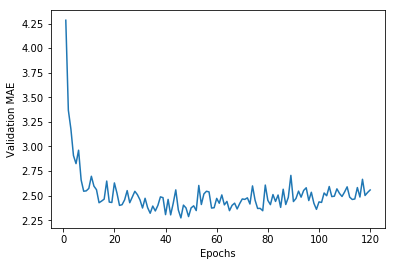

In [8]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

To create a smoother curve, we will use an exponential moving average. We will also skip plotting the first 10 point to give the plot get a better view of what is happening where the loss is lower, which is also where our model will reach its optimal values.

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [10]:
def nice_plot(avergare_mae):
    smooth_mae_history = smooth_curve(average_mae_history[10:])

    plt.plot(range(11, len(smooth_mae_history) + 11), smooth_mae_history)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

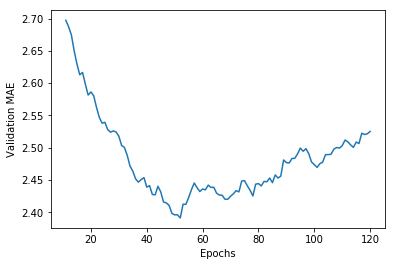

In [11]:
nice_plot(average_mae_history)

Judging by our above plot, it looks like our model reaches minimal loss around 50 epochs. After that point, our model appears to over fit to the training data, so we should only train our model to 50 epochs

In [16]:
def final_training():
    model = build_model()
    model.fit(train_data, train_targets, epochs=50, batch_size=16, verbose=0)
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    print('MAE score: ' + str(test_mae_score))

In [17]:
final_training()

102/102 [==============================] - 0s 1ms/step
MAE score: 2.755602658963671


The output from our network is in thousands of dollars, so our MAE score means that our model was 2,756 dollars off on average. That's not great, but it can be improved. We will cover that later.